In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('..'))
from backtracking import resolver
from greedy_pakku import greedy_pakku
from prog_lineal import prog_lineal

import time, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
SEED = 67910
CANT_GRUPOS = 3
MIN_TAM = 12 #12
MAX_TAM = 19 #19
MIN_HAB = 10
MAX_HAB = 1000
REPS =5 #5

In [11]:
def generar_habilidades(rng, n):
    return rng.integers(MIN_HAB, MAX_HAB, size=n).tolist()

In [12]:
def measure_methods(methods, sizes, reps):
    """
    Ejecuta mediciones para varios métodos.

    - methods: dict nombre -> callable(habilidades) que ejecuta el método.
               La callable puede devolver (valor, part) o cualquier cosa; aquí solo medimos tiempo.
    - sizes: iterable de tamaños (n) a probar
    - reps: repeticiones por tamaño
    - generar_habilidades_fn: callable(n) -> lista de valores. Si None, utiliza valores random [1,100].
    - devuelve: DataFrame con columnas ['method','tam','iter','tiempo']
    """
    filas = []
    total = len(methods) * len(sizes) * reps
    idx = 0

    for method_name, method_fn in methods.items():
        rng = np.random.default_rng(SEED)
        for i in range(reps):
            for tam in sizes:
                habilidades = generar_habilidades(rng, tam)
                idx += 1
                start = time.perf_counter()
                # ejecutar método (ignorar retorno)
                _ = method_fn(deepcopy(habilidades))
                dur = time.perf_counter() - start

                filas.append({
                    "method": method_name,
                    "tam": int(tam),
                    "iter": i,
                    "tiempo": float(dur)
                })

                pct = idx / total * 100
                sys.stdout.write(f"\r— ejec {idx}/{total} ({pct:5.1f}%)")
                sys.stdout.flush()
    print()
    df = pd.DataFrame(filas)
    return df

In [13]:
def summarize_by_size(df):
    """
    Devuelve summary por (method, tam) con median, mean, p25, p75, std, count.
    """
    agg = df.groupby(["method","tam"])["tiempo"].agg(
        median="median",
        mean="mean",
        std="std",
        count="count",
        p25=lambda x: np.percentile(x, 25),
        p75=lambda x: np.percentile(x, 75)
    ).reset_index()
    return agg

In [14]:
import numpy as np

def fit_model(summary, fit_spec=None):
    """
    Ajusta modelos según fit_spec y devuelve dict method -> (predict_fn, params, model_name)

    - summary: DataFrame con columnas ['method','tam','median', ...] (output de summarize_by_size)
    - fit_spec: dict { method_name: model_name } donde model_name ∈ {"exp", "nlogn", None}
                Si fit_spec es None -> aplica "exp" por defecto a todos métodos.
    Retorna:
      fits: dict method -> {"model": model_name, "predict": predict_fn or None, "params": params or None}
    """
    fits = {}
    methods = summary["method"].unique()

    # Si no especificaste nada, por defecto "exp" para todos
    if fit_spec is None:
        fit_spec = {m: "exp" for m in methods}

    for m in methods:
        model = fit_spec.get(m, None)
        s = summary[summary["method"] == m].sort_values("tam")
        x = s["tam"].values.astype(float)
        y = s["median"].values.astype(float)
        mask = y > 0

        if model is None:
            fits[m] = {"model": None, "predict": None, "params": None}
            continue

        if model == "exp":
            if mask.sum() < 2:
                fits[m] = {"model": "exp", "predict": None, "params": None}
                continue
            # log-linear fit: log y = logA + b * x
            coeffs = np.polyfit(x[mask], np.log(y[mask]), 1)
            b, logA = float(coeffs[0]), float(coeffs[1])
            predict = lambda xv, b=b, logA=logA: np.exp(logA + b * np.array(xv))
            params = {"b": b, "A": float(np.exp(logA))}
            fits[m] = {"model": "exp", "predict": predict, "params": params}
            continue

        if model == "nlogn":
            if mask.sum() < 2:
                fits[m] = {"model": "nlogn", "predict": None, "params": None}
                continue
            x_logn = x * np.log(np.where(x > 0, x, 1.0))
            coeffs = np.polyfit(x_logn[mask], y[mask], 1)
            a, bb = float(coeffs[0]), float(coeffs[1])
            predict = lambda xv, a=a, bb=bb: a * (np.array(xv) * np.log(np.where(np.array(xv) > 0, np.array(xv), 1.0))) + bb
            params = {"a": a, "b": bb}
            fits[m] = {"model": "nlogn", "predict": predict, "params": params}
            continue

        fits[m] = {"model": None, "predict": None, "params": None}

    return fits


In [15]:
def plot_comparison(df, fit_spec=None, ylim=None, save_path=None, figsize=(9,5)):
    """
    - df: DataFrame con columnas ['method','tam','iter','tiempo']
    - summary: output de summarize_by_size(df)
    - fits: dict method -> either
             - (predict_fn, params)
             - {"model":..., "predict":predict_fn, "params":params}
    """
    summary = summarize_by_size(df)
    methods = summary["method"].unique()
    palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = {m: palette[i % len(palette)] for i, m in enumerate(methods)}

    plt.figure(figsize=figsize)

    # PUNTOS INDIVIDUALES
    for m in methods:
        sub = df[df["method"] == m]
        plt.scatter(
            sub["tam"],
            sub["tiempo"],
            alpha=0.9,
            s=14,
            color=colors[m],
            marker="x",
            label=f"Ejecución {m}"
        )

    # ERRORBARS
    for m in methods:
        s = summary[summary["method"] == m].sort_values("tam")
        x = s["tam"].values
        y = s["median"].values
        yerr = np.vstack([y - s["p25"].values, s["p75"].values - y])

        plt.errorbar(
            x, y, yerr=yerr,
            fmt='-o',
            alpha=.5,
            color=colors[m],
            linewidth=2,
            markersize=6,
            capsize=4,
            label=f"{m} median (p25-p75)"
        )

    # AJUSTE
    fits = fit_model(summary, fit_spec=fit_spec) if fit_spec else None
    if fits is not None:
        xs = np.linspace(df["tam"].min(), df["tam"].max(), 300)
        for m in methods:
            entry = fits.get(m, None)
            predict = None
            model_name = None

            if isinstance(entry, tuple) and len(entry) == 2:
                predict, params = entry
            elif isinstance(entry, dict):
                predict = entry.get("predict", None)
                model_name = entry.get("model", None)

            if predict is not None:
                try:
                    yfit = predict(xs)
                    label = f"{m} fit"
                    if model_name:
                        label = f"{m} fit ({model_name})"

                    plt.plot(xs, yfit,
                             linestyle='--',
                             color=colors[m],
                             alpha=0.9,
                             linewidth=1,
                             label=label)
                except Exception as e:
                    print(f"warning: fit for method '{m}' failed: {e}")

    plt.xlabel("Cantidad de habilidades (n)")
    plt.ylabel("Tiempo de ejecución (s)")
    plt.title("Comparación tiempos: métodos")

    if ylim:
        plt.ylim(ylim)

    plt.grid(linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()



# Comparaciones Tiempos

### BT Ordenado vs. No Ordenado

— ejec 80/80 (100.0%)


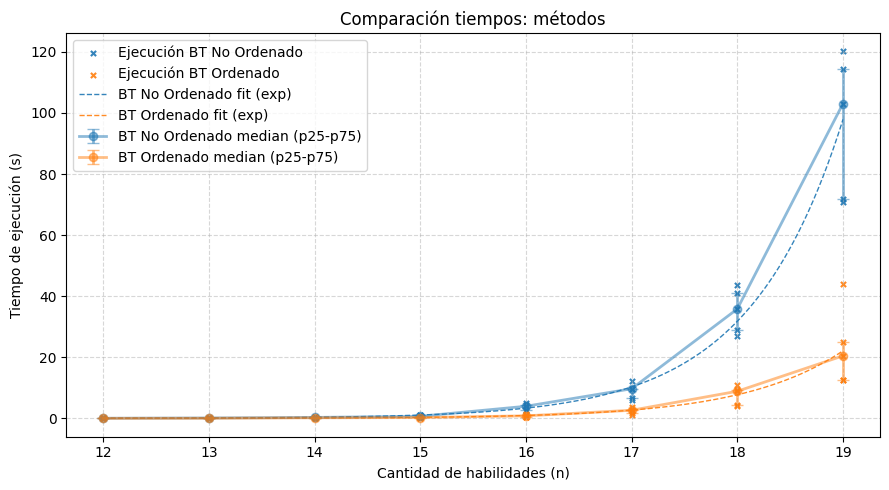

In [16]:
methods = {
    "BT Ordenado": (lambda h: resolver(CANT_GRUPOS, h, True)),
    "BT No Ordenado": (lambda h: resolver(CANT_GRUPOS, h, False))  # wrapper ignora retorno
}

sizes = list(range(MIN_TAM, MAX_TAM+1))

df_all = measure_methods(methods, sizes, reps=REPS)

fit_spec = {
    "BT Ordenado": "exp",
    "BT No Ordenado": "exp",
    # None  para no ajustar
}

plot_comparison(df_all, fit_spec=fit_spec, save_path="../informe/img/comparacion_bt_ordenado_vs_no_ordenado.png")

### BT vs. Greedy(Pakku)

— ejec 80/80 (100.0%)


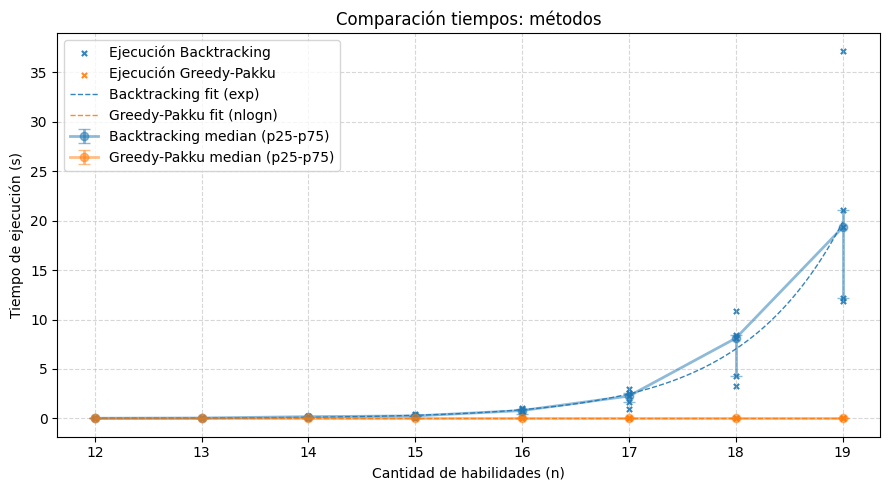

In [17]:
methods = {
    "Backtracking": (lambda h: resolver(CANT_GRUPOS, h, True)),
    "Greedy-Pakku": (lambda h: greedy_pakku(CANT_GRUPOS, h)[0])  # wrapper ignora retorno
}

sizes = list(range(MIN_TAM, MAX_TAM+1))

df_all = measure_methods(methods, sizes, reps=REPS)

fit_spec = {
    "Backtracking": "exp",
    "Greedy-Pakku": "nlogn",
    # None  para no ajustar
}

plot_comparison(df_all, fit_spec=fit_spec, save_path="../informe/img/comparacion_tiempos_pakku_vs_bt.png")

### PL vs BT

— ejec 80/80 (100.0%)


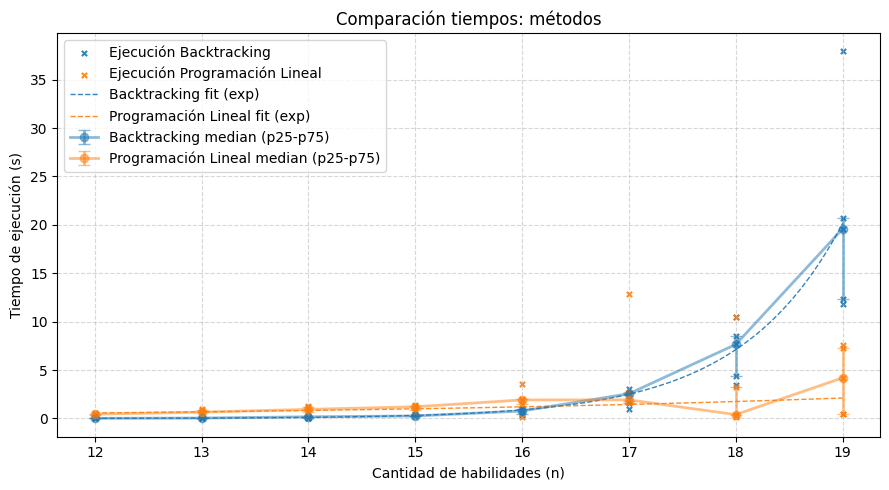

In [18]:
methods = {
    "Backtracking": (lambda h: resolver(CANT_GRUPOS, h, True)),
    "Programación Lineal": (lambda h: prog_lineal(CANT_GRUPOS, h)[0])  # wrapper ignora retorno
}

sizes = list(range(MIN_TAM, MAX_TAM+1))

df_all = measure_methods(methods, sizes, reps=REPS)

fit_spec = {
    "Backtracking": "exp",
    "Programación Lineal": "exp",
    # None  para no ajustar
}

plot_comparison(df_all, fit_spec=fit_spec, save_path="../informe/img/comparacion_tiempos_pl_vs_bt.png")